In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import sys
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
sys.path.append('/Users/ramtinyazdanian/PycharmProjects/job_skill_trend_analysis/')
from utilities.common_utils import *
from utilities.analysis_utils import *
from utilities.pandas_utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scipy.stats import shapiro, anderson, probplot
from scipy import stats

In [2]:
root_data_path = '/Users/ramtinyazdanian/Downloads/jobtech/'
all_filenames = os.listdir(root_data_path)
all_dataframes = [pd.read_csv(os.path.join(root_data_path,filename)) 
                  for filename in all_filenames if filename[-3:] == 'csv' and filename[0] != '~']

In [3]:
df_all = pd.concat(all_dataframes)

In [4]:
df_all.head()

,jobId,jobUrl,jobTitle,jobDescription,datePosted,companyId,companyName,industryId,yoxMin,yoxMax,finalWageMin,finalWageMax,countryCode,skills,qualifications
0,0023502d439415ad8bbdb62a7020114c0e67ed5824e0b6...,https://sg.jobsdb.com/job/rd/adbd75e33b3a1415d...,Admin & Accounts Executive,Roles &amp; ResponsibilitiesJob Description<br...,2020-01-01,4a536df3d73f2123c14b4a1d5fa6b8ecfd9352b3c390f1...,MILWORKS SOLUTIONS PTE. LTD.,InfoComm Technologies,0,0,1150.0,1917.0,SG,"[{'skill': 'accounts payable accounting', 'ski...",['Bachelors']
1,0053799fde5277b3ee431bb57f0820ef01a4c6abf7246d...,https://sg.jobsdb.com/job/rd/adbd75e33b3a1415d...,Admin & Accounts Executive,Roles &amp; ResponsibilitiesJob Description<br...,2020-01-01,4a536df3d73f2123c14b4a1d5fa6b8ecfd9352b3c390f1...,MILWORKS SOLUTIONS PTE. LTD.,InfoComm Technologies,0,0,1150.0,1917.0,SG,"[{'skill': 'accounts payable accounting', 'ski...",['Bachelors']
2,009bd6514108fed114208aa85c28a2c318291978e301ee...,https://sg.jobsdb.com/job/rd/adbd75e33b3a1415d...,Admin & Accounts Executive,Roles &amp; ResponsibilitiesJob Description<br...,2020-01-01,4a536df3d73f2123c14b4a1d5fa6b8ecfd9352b3c390f1...,MILWORKS SOLUTIONS PTE. LTD.,InfoComm Technologies,0,0,1150.0,1917.0,SG,"[{'skill': 'accounts payable accounting', 'ski...",['Bachelors']
3,00edb53a28e215cfb3f8d90594fac0872919bba772d842...,https://sg.jobsdb.com/job/rd/adbd75e33b3a1415d...,Admin & Accounts Executive,Roles &amp; ResponsibilitiesJob Description<br...,2020-01-01,4a536df3d73f2123c14b4a1d5fa6b8ecfd9352b3c390f1...,MILWORKS SOLUTIONS PTE. LTD.,InfoComm Technologies,0,0,1150.0,1917.0,SG,"[{'skill': 'accounts payable accounting', 'ski...",['Bachelors']
4,01103f9a143bdecf5e09484315bd1a2fb36fe9e7acbca6...,https://sg.jobsdb.com/job/rd/adbd75e33b3a1415d...,Admin & Accounts Executive,Roles &amp; ResponsibilitiesJob Description<br...,2020-01-01,4a536df3d73f2123c14b4a1d5fa6b8ecfd9352b3c390f1...,MILWORKS SOLUTIONS PTE. LTD.,InfoComm Technologies,0,0,1150.0,1917.0,SG,"[{'skill': 'accounts payable accounting', 'ski...",['Bachelors']


In [50]:
df_all.industryId.unique()

array(['InfoComm Technologies'], dtype=object)

In [5]:
df_all_useful_cols = df_all[['companyName', 'industryId', 'datePosted', 'skills']].rename(columns={
    'companyName': 'Company', 'industryId': 'Industry', 'datePosted': 'Date', 'skills': 'Skill List'
})

df_all_useful_cols['Skill List'] = df_all_useful_cols['Skill List'].apply(eval)
df_all_useful_cols['Date'] = pd.to_datetime(df_all_useful_cols['Date'])
company_totals = divide_into_periods(df_all_useful_cols, ['Company'], result_col_name='Total')

df_all_useful_cols = explode(df_all_useful_cols, ['Skill List'])
df_all_useful_cols = df_all_useful_cols.loc[df_all_useful_cols['Skill List'].apply(lambda x: x != '')]

df_all_useful_cols['Skill'] = df_all_useful_cols['Skill List'].apply(lambda x: x['skill'])
df_all_useful_cols['Skill Type'] = df_all_useful_cols['Skill List'].apply(lambda x: x['skillTypeId'])
df_all_useful_cols = df_all_useful_cols.drop(columns='Skill List')

In [6]:
df_all_useful_cols.head()

,Company,Date,Industry,Skill,Skill Type
0,MILWORKS SOLUTIONS PTE. LTD.,2020-01-01,InfoComm Technologies,accounts payable accounting,2
1,Red Hat,2018-01-01,InfoComm Technologies,virtualization technology,1
2,KEYREPLY PTE. LTD.,2019-01-03,InfoComm Technologies,account management,2
3,KEYREPLY PTE. LTD.,2019-01-03,InfoComm Technologies,business development,1
4,KEYREPLY PTE. LTD.,2019-01-03,InfoComm Technologies,communication,4


If we want to filter out the irrelevant skill types (which I need to figure out), here is the place.

In [7]:
df_all_useful_cols['Skill Type'].unique()

array([2, 1, 4, 3])

In [8]:
df_all_useful_cols.loc[df_all_useful_cols['Skill Type'] == 1].groupby('Skill').count().\
            sort_values('Date', ascending=False).index.values.tolist()

['computer science',
 'cloud technology',
 'regulatory compliance',
 'sops/best practices',
 'consulting',
 'unix/linux',
 'hardware',
 'information technology',
 'business finance',
 'business development',
 'microsoft windows os',
 'web services',
 'social media (facebook)',
 'legal/law',
 'computer engineering',
 'data center',
 'telecommunications',
 'social media',
 'healthcare',
 'operating systems',
 'supply chain & logistics',
 'scrum/agile',
 'amazon web services',
 'information systems',
 'e-commerce',
 'virtualization technology',
 'web applications',
 'sdlc',
 'advertising',
 'software-as-a-service (saas)',
 'investment',
 'open source technology',
 'vmware',
 'manufacturing',
 'system engineering',
 'genetic information',
 'continuous improvement',
 'human resource development',
 'b2b engagement',
 'business administration',
 'machine learning algorithms',
 'compensation & benefits',
 'artificial intelligence',
 'iso',
 'big data',
 'marketing strategy',
 'cyber security',

Skill type 3 is languages and licenses, 4 is general soft skills.

Types 1 and 2 are both hard skills, the difference being that type 1 deals with more generic skills and with clusters, while 2 deals with specific technology for the most part.

In [9]:
absolute_start = np.datetime64('2017-01-01')
absolute_end = np.datetime64('2020-01-01')

In [90]:
skills_df = divide_into_periods(df_all_useful_cols.loc[(df_all_useful_cols['Skill Type'] == 1) | 
                                                       (df_all_useful_cols['Skill Type'] == 2)], 
                                ['Company', 'Skill'], 
                                absolute_start, absolute_end, result_col_name='Job Postings Raw')
skills_df = pd.merge(skills_df, company_totals, on = ['Company', 'Date'])
skills_df['Job Postings'] = skills_df['Job Postings Raw'] / skills_df['Total']

In [91]:
skills_df.sort_values('Date').head(10)

,Company,Skill,Date,Job Postings Raw,Total,Job Postings
158229,Radiance Communications Pte Ltd,negotiation,2017-01-01,1,6,0.166667
14209,Agilent Technologies Singapore (International)...,matlab,2017-01-01,1,20,0.050000
14208,Agilent Technologies Singapore (International)...,mass spectrometry,2017-01-01,1,20,0.050000
14207,Agilent Technologies Singapore (International)...,marketing strategy,2017-01-01,2,20,0.100000
14206,Agilent Technologies Singapore (International)...,marketing,2017-01-01,8,20,0.400000
14205,Agilent Technologies Singapore (International)...,market research,2017-01-01,1,20,0.050000
14204,Agilent Technologies Singapore (International)...,market analysis,2017-01-01,1,20,0.050000
14203,Agilent Technologies Singapore (International)...,manufacturing workflow,2017-01-01,4,20,0.200000
14202,Agilent Technologies Singapore (International)...,manufacturing,2017-01-01,9,20,0.450000
14201,Agilent Technologies Singapore (International)...,maintenance management,2017-01-01,3,20,0.150000


In [178]:
len(skills_df.Skill.unique())

1989

In [179]:
# skills_df[['Skill']].drop_duplicates().sort_values('Skill').to_csv('./all_skills.csv')

## Computing the true emerging skills

In [92]:
monthly_totals = compute_total_values(skills_df)
total_log = compute_total_log_mean(skills_df)

In [93]:
start_and_end_dates = [(np.datetime64('2018-01-01'), np.datetime64('2019-01-01')), 
                       (np.datetime64('2019-01-01'), np.datetime64('2020-01-01')),
                       (np.datetime64('2018-01-01'), np.datetime64('2020-01-01'))]

# start_and_end_dates = [(np.datetime64('2017-01-01'), np.datetime64('2018-01-01')), 
#                        (np.datetime64('2017-01-01'), np.datetime64('2019-01-01')), 
#                        (np.datetime64('2018-01-01'), np.datetime64('2019-01-01')), 
#                        (np.datetime64('2019-01-01'), np.datetime64('2020-01-01')),
#                        (np.datetime64('2018-01-01'), np.datetime64('2020-01-01')),
#                        (np.datetime64('2017-01-01'), np.datetime64('2020-01-01'))]

total_values = [get_period_of_time(monthly_totals, start_and_end_dates[i][0], start_and_end_dates[i][1]).sum()[0]
                for i in range(len(start_and_end_dates))]

In [146]:
skill_trends = [logsum_trend_slope_wrapper(skills_df, 
                                                  start_and_end_dates[i][0], start_and_end_dates[i][1],
                                                  total_log, nologtest=False) 
                                for i in range(len(start_and_end_dates))]

Start: 2018-01-01
End: 2019-01-01
Number of skills: 1655
             Slope    Intercept  Acceleration    Spikiness
count  1655.000000  1655.000000   1655.000000  1655.000000
mean      0.158721     1.446285      8.463814     6.461865
std       0.432342     5.712575     55.700900    99.283268
min      -0.548440    -1.284287    -13.580149  -904.305510
25%      -0.011574    -0.583134     -0.004498    -7.047773
50%       0.033700    -0.245158      0.023641     4.953123
75%       0.144709     0.856901      0.462647     7.907496
max       4.513627    96.475509   1454.015342  1633.945775
Start: 2019-01-01
End: 2020-01-01
Number of skills: 1822
             Slope    Intercept  Acceleration    Spikiness
count  1822.000000  1822.000000   1822.000000  1822.000000
mean      0.068955     3.663056      6.702457    -2.129086
std       0.386416    11.290596     61.946377    49.094526
min      -0.853084    -1.293493    -78.824929  -605.037065
25%      -0.043166    -0.522689     -0.035249   -16.698421
5

In [147]:
skill_trends[0].sort_values('Slope', ascending=False).head(20)

,Slope,Intercept,Acceleration,Spikiness,Job Postings Raw
Skill,,,,,
sales,4.513627,96.475509,1454.015342,5.697924,3776
marketing,4.390852,51.218714,867.197076,6.691463,2273
general programming,3.543484,31.632115,472.458037,6.839899,1388
sops/best practices,3.390303,27.255931,401.961184,7.174362,1212
regulatory compliance,3.206152,23.747040,327.028298,6.355855,1050
coordination,3.158803,37.065176,436.601787,6.140742,1419
microsoft office (excel),3.046622,29.048251,339.759838,6.093582,1138
cloud technology,2.992485,40.720925,452.910864,6.490805,1778
project management,2.918549,39.193832,414.518206,6.236774,1663


In [148]:
skill_trends[1].corr(method='pearson')

,Slope,Intercept,Acceleration,Spikiness,Job Postings Raw
Slope,1.000000,0.624039,0.803758,0.018388,0.722404
Intercept,0.624039,1.000000,0.668107,0.050015,0.978547
Acceleration,0.803758,0.668107,1.000000,0.012904,0.765725
Spikiness,0.018388,0.050015,0.012904,1.000000,0.041819
Job Postings Raw,0.722404,0.978547,0.765725,0.041819,1.000000


In [149]:
skill_trends[1].corr(method='spearman')

,Slope,Intercept,Acceleration,Spikiness,Job Postings Raw
Slope,1.000000,-0.049299,0.631655,-0.059905,0.222675
Intercept,-0.049299,1.000000,0.126598,0.282994,0.906546
Acceleration,0.631655,0.126598,1.000000,-0.086305,0.155287
Spikiness,-0.059905,0.282994,-0.086305,1.000000,0.363307
Job Postings Raw,0.222675,0.906546,0.155287,0.363307,1.000000


In [150]:
emerging_skills = [threshold_logsum_trends_simple(skill_trends[i], total=total_values[i], col='Slope',
                                                  col_percentile_thresh=.7) 
                        for i in range(len(skill_trends))]

In [151]:
emerging_skills[0]

,Skill,Slope,Intercept,Acceleration,Spikiness,Job Postings Raw
0,3rd party logistics,0.201647,-1.006091,0.140818,5.468068,15
1,accident and incident response management,0.285162,0.781923,1.864207,6.616519,61
2,accounts payable accounting,0.203954,1.718990,1.203391,3.156693,70
3,accrual accounting,0.208350,-0.034679,0.630256,8.844190,34
4,active directory,0.216573,2.767153,2.742984,6.385965,89
...,...,...,...,...,...,...
141,terraform,0.215054,-0.955451,0.534997,13.740496,16
142,test-driven development,0.661741,-0.072602,6.702737,10.154437,88
143,treasury management,0.196532,-1.074630,0.205240,7.872350,14
144,vb,0.376987,1.226069,2.798977,4.864961,79


In [152]:
compare_emerging_skill_sets(emerging_skills, start_and_end_dates, sort_type='alpha')


Comparing 2018-01-01 to 2019-01-01 with 2019-01-01 to 2020-01-01

# of skills shared and exclusive to each date (in order)
31 115 98

The skills themselves:

Shared:

['accident and incident response management', 'accounts payable accounting', 'architectural design', 'confluence', 'corporate communications', 'dynamic host configuration protocol', 'enterprise web architecture', 'financial accounting', 'financial audit', 'full stack development', 'goods and services tax (gst)', 'google analytics', 'invoicing', 'it operations management (itom)', 'journalism', 'lifelong learning', 'mac os', 'microsoft office 365', 'network systems', 'openshift', 'oracle database', 'photography', 'practical malware analysis', 'publishing', 'ruby', 'search-engine marketing', 'service oriented architecture', 'social media (whatsapp)', 'support process', 'teaching', 'terraform']

Exclusive to 2018-01-01 to 2019-01-01

['3rd party logistics', 'accrual accounting', 'active directory', 'aml/cft', 'ansible', 'apa

Let's see the companies responsible for some of the weird skills.

In [153]:
def get_responsible_companies(df, skill, time_periods, time_index):
    filtered_df = get_period_of_time(df, time_periods[time_index][0], time_periods[time_index][1])
    filtered_df = filtered_df.loc[(filtered_df.Skill == skill)]
    return filtered_df[['Company', 'Skill', 'Job Postings Raw']].\
                groupby(['Company', 'Skill']).sum().sort_values('Job Postings Raw', ascending=False)

In [154]:
get_responsible_companies(skills_df, 'immunology', start_and_end_dates, 1)

,,Job Postings Raw
Company,Skill,
Singapore Immunology Network (SIgN),immunology,36
ACM biolabs,immunology,4
NUS Department of Microbiology and Immunology,immunology,2
CHUGAI PHARMABODY RESEARCH PTE. LTD.,immunology,1
Danaher,immunology,1
INVITROCUE PTE. LTD.,immunology,1
STEMCELL TECHNOLOGIES SINGAPORE PTE. LTD.,immunology,1


In [155]:
get_responsible_companies(skills_df, 'cancer biology', start_and_end_dates, 1)

,,Job Postings Raw
Company,Skill,
Singapore Immunology Network (SIgN),cancer biology,13
ACM biolabs,cancer biology,4
Agilent Technologies Singapore (International) Pte Ltd,cancer biology,3
INVITROCUE PTE. LTD.,cancer biology,2
BIOLIDICS LIMITED,cancer biology,1
Google,cancer biology,1
STAR ARRAY PTE. LTD.,cancer biology,1


In [156]:
get_responsible_companies(skills_df, 'material science', start_and_end_dates, 1)

,,Job Postings Raw
Company,Skill,
Gaia Science Pte. Ltd.,material science,6
Creative Technology Group of Companies,material science,5
HP SINGAPORE (PRIVATE) LIMITED,material science,4
RF360 SINGAPORE PTE. LTD.,material science,4
FACEBOOK SINGAPORE PTE. LTD.,material science,3
Institute of Materials Research & Engineering (IMRE),material science,3
DIALYSS PTE. LTD.,material science,2
Facebook,material science,2
MEDIATEK SINGAPORE PTE. LTD.,material science,2


In [157]:
get_responsible_companies(skills_df, 'genomics', start_and_end_dates, 1)

,,Job Postings Raw
Company,Skill,
Ericsson,genomics,37
Ericsson-Worldwide,genomics,31
TRAVERSE TECHNOLOGIES PTE. LTD.,genomics,4
Institute of Medical Biology (IMB),genomics,3
NUS Department of Microbiology and Immunology,genomics,2
Singapore Immunology Network (SIgN),genomics,2
Agilent Technologies Singapore (International) Pte Ltd,genomics,1
GOOGLE ASIA PACIFIC PTE. LTD.,genomics,1
IHIS - Integrated Health Information Systems Pte Ltd,genomics,1


In [158]:
get_responsible_companies(skills_df, 'printed circuit board (pcb)', start_and_end_dates, 1)

,,Job Postings Raw
Company,Skill,
ST Electronics (Info-comm Systems) Pte Ltd,printed circuit board (pcb),18
Aruba Networks,printed circuit board (pcb),5
Foxconn Singapore Pte Ltd,printed circuit board (pcb),5
ST Electronics (Training & Simulation Systems) Pte Ltd,printed circuit board (pcb),4
D'Crypt Pte Ltd,printed circuit board (pcb),3
RF360 SINGAPORE PTE. LTD.,printed circuit board (pcb),3
TCAM TECHNOLOGY PTE. LTD.,printed circuit board (pcb),3
ADDVALUE INNOVATION PTE LTD,printed circuit board (pcb),1
ADI-DESIGNS PTE. LTD.,printed circuit board (pcb),1


In [159]:
get_responsible_companies(skills_df, 'life science', start_and_end_dates, 1)

,,Job Postings Raw
Company,Skill,
Singapore Immunology Network (SIgN),life science,36
Agilent Technologies Singapore (International) Pte Ltd,life science,30
Medidata Solutions,life science,15
ZENTEK ENGINEERING PTE. LTD.,life science,11
MarkLogic,life science,10
Institute of Medical Biology (IMB),life science,8
BIO BASIC ASIA PACIFIC PTE. LTD.,life science,4
CHUGAI PHARMABODY RESEARCH PTE. LTD.,life science,4
DSM SINGAPORE INDUSTRIAL PTE. LTD.,life science,3


In [160]:
get_responsible_companies(skills_df, 'molecular biology', start_and_end_dates, 1)

,,Job Postings Raw
Company,Skill,
Singapore Immunology Network (SIgN),molecular biology,31
Institute of Medical Biology (IMB),molecular biology,8
CHUGAI PHARMABODY RESEARCH PTE. LTD.,molecular biology,4
Gaia Science Pte. Ltd.,molecular biology,3
INVITROCUE PTE. LTD.,molecular biology,2
NEW ENGLAND BIOLABS PTE. LTD.,molecular biology,2
NUS Department of Microbiology and Immunology,molecular biology,2
STAR ARRAY PTE. LTD.,molecular biology,2
STEMCELL TECHNOLOGIES SINGAPORE PTE. LTD.,molecular biology,1


In [161]:
get_responsible_companies(skills_df, 'gcp (good clinical practice)', start_and_end_dates, 1)

,,Job Postings Raw
Company,Skill,
ST Electronics (Info-comm Systems) Pte Ltd,gcp (good clinical practice),10
Google,gcp (good clinical practice),7
F5 Networks,gcp (good clinical practice),7
FUJITSU ASIA PTE LTD,gcp (good clinical practice),6
GOOGLE ASIA PACIFIC PTE. LTD.,gcp (good clinical practice),6
F5 NETWORKS SINGAPORE PTE LTD,gcp (good clinical practice),6
CIRCLES LIFE TECHNOLOGY PTE. LTD.,gcp (good clinical practice),5
VIRTUSA SINGAPORE PRIVATE LIMITED,gcp (good clinical practice),5
LIBERTY WIRELESS PTE. LTD.,gcp (good clinical practice),3


In [162]:
skills_df.loc[skills_df.Company == 'Singapore Immunology Network (SIgN)', 'Skill'].unique()

array(['artificial intelligence', 'biochemistry', 'bioinformatics',
       'biostatistics', 'biotechnology', 'c++', 'cancer biology',
       'cell biology', 'computational biology', 'computer science',
       'customer education', 'data analytics', 'data/text mining',
       'database optimisation', 'deep learning',
       'dimensionality reduction', 'dna', 'drug development',
       'experiments', 'gene sequencing', 'general algorithms',
       'general microscopy', 'general programming', 'genetic engineering',
       'genomics', 'image analytics', 'immunology', 'immunotherapy',
       'java', 'life science', 'machine learning algorithms',
       'maintenance management', 'mathematics', 'matlab',
       'medical disease', 'model organism', 'molecular biology',
       'next-gen sequencing (ngs)', 'perl', 'predictive modelling',
       'python', 'r&d', 'r-programming', 'recruitment policy',
       'shell scripts', 'statistical analysis', 'statistics',
       't cell receptor', 'talent r

### Evaluating the sets of trending skills based on known (and obvious) ground truth

In [163]:
ground_truth_base = pd.DataFrame({'Skill': 
                    ['vue.js', 'deep learning', 'tensorflow', 'kubernetes', 'graphql', 'cryptocurrency',
                     'redux', 'apache kafka', 'salesforce lightning', 'aws lambda', 'aws redshift', 'domo',
                     'data lakes', 'serverless computing', 'blockchain technology', 'amazon aurora', 
                     'docker', 'looker', 'autonomous cars', 'financial microservices', 'microservices',
                     'data visualization', 'apache hive', 'apache hadoop', 'apache flume', 'predictive models',
                     ]})

In [164]:
compute_prec_recall(emerging_skills[0], ground_truth_base)

{'cryptocurrency', 'tensorflow', 'apache kafka', 'graphql', 'blockchain technology', 'apache hive'}
6 146 26


(0.0410958904109589, 0.23076923076923078, 0.06976744186046512)

In [165]:
compute_prec_recall(emerging_skills[1], ground_truth_base)

set()
0 129 26


ZeroDivisionError: float division by zero

In [166]:
compute_prec_recall(emerging_skills[2], ground_truth_base)

{'tensorflow', 'apache kafka', 'deep learning', 'vue.js', 'blockchain technology', 'apache hive'}
6 163 26


(0.03680981595092025, 0.23076923076923078, 0.06349206349206349)

## Looking at the distributions of computed quantities

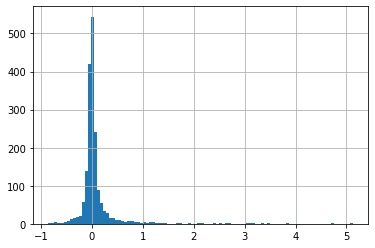

In [167]:
skill_trends[1].Slope.hist(bins=100)
#plt.yscale('log')

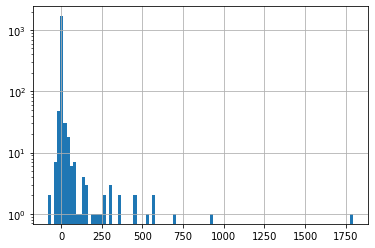

In [168]:
skill_trends[1].Acceleration.hist(bins=100)
plt.yscale('log')

In [169]:
skill_trends[2].Slope.quantile(.8), \
            skill_trends[2].Slope.quantile(.9), skill_trends[2].Slope.mean() 

(0.13635635464198795, 0.3689728966053627, 0.14127501729047107)

Interestingly, as this plot and the summary statistics show, the Slope values are way more skewed to the right here, and the Generalised Normals that we had used before will fail.

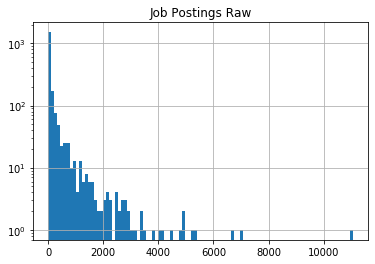

In [170]:
skills_df[['Skill', 'Job Postings Raw']].groupby('Skill').sum().\
                        hist(bins = 100)
plt.yscale('log')

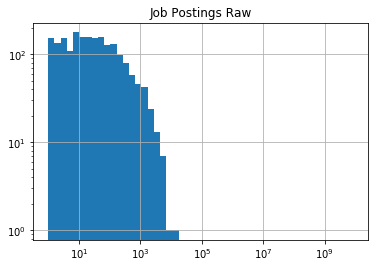

In [171]:
skills_df[['Skill', 'Job Postings Raw']].groupby('Skill').sum().\
                        hist(bins = np.logspace(np.log(1), np.log(20000), 50))
plt.yscale('log')
plt.xscale('log')

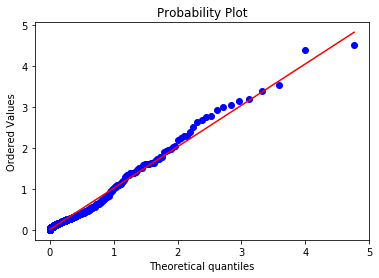

In [172]:
probplot(skill_trends[0].loc[skill_trends[0].Slope > 0].Slope.values, dist=stats.gamma, 
         sparams=(.24), fit=True, plot=plt)
plt.show()

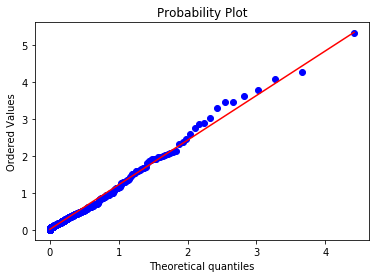

In [173]:
probplot(skill_trends[2].loc[skill_trends[2].Slope > 0].Slope.values, dist=stats.gamma, 
         sparams=(.16), fit=True, plot=plt)
plt.show()

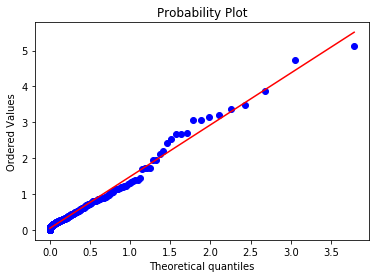

In [174]:
probplot(skill_trends[1].loc[skill_trends[1].Slope > 0].Slope.values, dist=stats.gamma, 
         sparams=(.12), fit=True, plot=plt)
plt.show()

Generally, it's safe to say that the slope values generally follow two back to back Gamma distributions, one for the positives and one for the negatives. We don't really care about the negatives (because they're the _declining_ skills, while we're only interested in the growing skills), meaning that we can just discard the negatives and fit a Gamma to the positives.

The mean and variance of this distribution are equal to the shape parameter, which makes it very interesting: it's a distribution with faster than exponential decay, meaning that even the mean can be pretty restrictive!

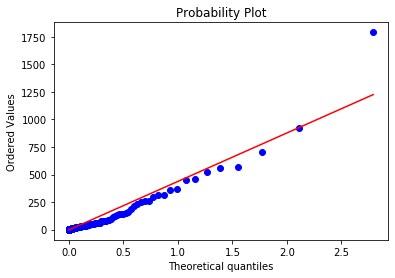

In [175]:
probplot(skill_trends[1].loc[skill_trends[1].Acceleration > 0].Acceleration.values, dist=stats.gamma, 
         sparams=(.04), fit=True, plot=plt)
plt.show()

The acceleration is a Gamma if we remove the very extreme outliers, but with _extremely low_ shape parameters.

((array([2.37219539e-50, 7.53259560e-45, 5.90216289e-42, ...,
         2.79319399e+00, 3.16517190e+00, 3.89215578e+00]),
  array([    1,     1,     1, ...,  6644,  7007, 11054])),
 (2298.5287322368986, 29.594890020327227, 0.9943196026719533))

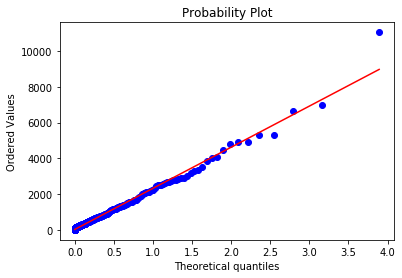

In [176]:
probplot(skills_df[['Skill', 'Job Postings Raw']].groupby('Skill').sum()['Job Postings Raw'].values, 
         dist=stats.gamma, 
         sparams=(.07), fit=True, plot=plt)

## Analysis with companies